In [1]:
import sys

sys.path.append("../")

In [2]:
import requests
import time
import pandas as pd
import numpy as np
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from stats_arb.tests import adf_test, kpss_test, cal_half_life, pp_test
from datetime import datetime, timedelta
from ta.volatility import BollingerBands

import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 6) # (w, h)
plt.ioff()

In [3]:
API_BASE = 'https://fapi.binance.com/fapi/v1/'
DATA_PATH = '/mnt/d/Working/PersonalProjects/Trading/trading-agent/crypto-pair-trading/data/crypto/'
TIMEFRAME = '1h'
lookback = 30*6

# TIMEFRAME = '5m'
# lookback = 20


In [4]:


LABELS = [
    'open_time',
    'open',
    'high',
    'low',
    'close',
    'volume',
    'close_time',
    'quote_asset_volume',
    'number_of_trades',
    'taker_buy_base_asset_volume',
    'taker_buy_quote_asset_volume',
    'ignore'
]

DROP_COLUMNS=[
    'close_time',
    'quote_asset_volume',
    'number_of_trades',
    'taker_buy_base_asset_volume',
    'taker_buy_quote_asset_volume',
    'ignore'
]


def get_batch(symbol, interval='1m', start_time=0, limit=400):
    """Use a GET request to retrieve a batch of candlesticks. Process the JSON into a pandas
    dataframe and return it. If not successful, return an empty dataframe.
    """

    params = {
        'symbol': symbol,
        'interval': interval,
        'startTime': start_time,
        'limit': limit
    }
    try:
        # timeout should also be given as a parameter to the function
        response = requests.get(f'{API_BASE}klines', params, timeout=30)
    except requests.exceptions.ConnectionError:
        print('Connection error, Cooling down for 5 mins...')
        time.sleep(15)
        return get_batch(symbol, interval, start_time, limit)

    except requests.exceptions.Timeout:
        print('Timeout, Cooling down for 5 min...')
        time.sleep(15)
        return get_batch(symbol, interval, start_time, limit)

    if response.status_code == 200:
        return pd.DataFrame(response.json(), columns=LABELS)
    
    print(f'Got erroneous response back {symbol}: {response}. {response.text}')
    return pd.DataFrame([])


def get_candles(base, quote, start_date: datetime, end_date=None, interval='1m'):
    batches = []

    if end_date is None:
        end_date = datetime.utcnow()

    last_timestamp = int(start_date.timestamp()) * 1000
    # gather all candlesticks available, starting from the last timestamp loaded from disk or 0
    # stop if the timestamp that comes back from the api is the same as the last one
    previous_timestamp = None

    while previous_timestamp != last_timestamp:
        # stop if we reached data from today
        if datetime.fromtimestamp(last_timestamp / 1000) >= end_date:
            break

        previous_timestamp = last_timestamp

        new_batch = get_batch(
            symbol=base + quote,
            interval=interval,
            start_time=last_timestamp
        )

        # requesting candles from the future returns empty
        # also stop in case response code was not 200
        if new_batch.empty:
            break

        last_timestamp = new_batch['open_time'].max()

        # sometimes no new trades took place yet on date.today();
        # in this case the batch is nothing new
        if previous_timestamp == last_timestamp:
            break

        batches.append(new_batch)
        last_datetime = datetime.fromtimestamp(last_timestamp / 1000)

        covering_spaces = 20 * ' '
        print(datetime.now(), base, quote, interval, str(last_datetime) + covering_spaces, end='\r', flush=True)

    if len(batches) > 0:
        # write clean version of csv to parquet
        df = pd.concat(batches, ignore_index=True)
        df.drop(columns=DROP_COLUMNS, inplace=True)
        df['open_time'] = pd.to_datetime(df['open_time'], unit='ms')
        df.set_index('open_time', inplace=True)
        df = df[~df.index.duplicated(keep='first')]
        return df



In [5]:
# import requests

# url = "https://fapi.binance.com/fapi/v1/exchangeInfo"

# payload={}
# headers = {}

# response = requests.request("GET", url, headers=headers, data=payload).json()

# symbols = [s['symbol'] for s in response['symbols'] if s['contractType'] == 'PERPETUAL' and s['quoteAsset'] == 'USDT']
# # symbols[100:]
# symbols = symbols[:50]
# len(symbols)


In [6]:
# symbols = pd.read_csv(f'/mnt/d/Working/PersonalProjects/Trading/trading-agent/crypto-pair-trading/data/symbols.csv')['symbol'].values.tolist()
symbols = ['BTCUSDT',
'ETHUSDT',
'BCHUSDT',
'XRPUSDT',
'LTCUSDT',
'ETCUSDT',
'LINKUSDT',
'XLMUSDT',
'ADAUSDT',
'BNBUSDT',
'ATOMUSDT',
'ALGOUSDT',
'DOTUSDT',
'SOLUSDT',
'AVAXUSDT',
'MATICUSDT',
'XMRUSDT',
'NEARUSDT',
'AVAXUSDT',
'ATOMUSDT',
'MANAUSDT',
'UNIUSDT',
'BCHUSDT']
symbols = [s.replace('USDT', '') for s in symbols]

data = []
start_time = datetime.utcnow() - timedelta(days=lookback)

for symbol in symbols:
    df = pd.read_csv(f'{DATA_PATH}/{TIMEFRAME}/{symbol}-USDT.csv', parse_dates=['open_time'], index_col=['open_time'])
    df = df[df.index >= start_time].copy()
    # print('start time', df.index[-1].to_pydatetime())

    df1 = get_candles(
        base=symbol, 
        quote='USDT', 
        start_date=df.index[-1].to_pydatetime(),
        # end_date=datetime.now() - timedelta(days=15),
        interval=TIMEFRAME
    )
    if df1 is not None:
        df = pd.concat([df, df1])
        df = df[~df.index.duplicated(keep='first')]

    df.rename(columns={'close': symbol}, inplace=True)
    # the data is too long, just limit to recent period
    log = np.log(df[symbol].astype(np.float32))
    data.append(log)

df = pd.concat(data, axis=1)
df = df.dropna(axis=1, how='all')
# df.dropna(inplace=True, how='any')

# our of sample
# df = df[df.index <= datetime.now() - timedelta(days=15)].copy()

df.tail()

,BTC,ETH,BCH,XRP,LTC,ETC,LINK,XLM,ADA,BNB,...,SOL,AVAX,MATIC,XMR,NEAR,AVAX,ATOM,MANA,UNI,BCH
open_time,,,,,,,,,,,,,,,,,,,,,
2023-01-10 22:00:00,9.765368,7.195870,4.672922,-1.046684,4.392348,3.000968,1.813847,-2.532501,-1.135069,5.622030,...,2.789446,2.543254,-0.157941,5.080410,0.492865,2.543254,2.418767,-0.923315,1.752152,4.672922
2023-01-10 23:00:00,9.765880,7.196911,4.676281,-1.047824,4.393461,3.006771,1.818888,-2.531244,-1.132272,5.624090,...,2.784456,2.543961,-0.152802,5.082397,0.497132,2.543961,2.426306,-0.911303,1.754577,4.676281
2023-01-11 00:00:00,9.767479,7.198348,4.680278,-1.048109,4.396053,3.003700,1.821480,-2.530741,-1.133825,5.623187,...,2.781982,2.541681,-0.151521,5.084443,0.495306,2.541681,2.426836,-0.919797,1.757513,4.680278
2023-01-11 01:00:00,9.767100,7.198595,4.680185,-1.052110,4.394079,3.001118,1.818077,-2.535779,-1.133825,5.623187,...,2.778136,2.538368,-0.152219,5.086175,0.494086,2.538368,2.421878,-0.925836,1.751458,4.680185
2023-01-11 02:00:00,9.765937,7.197009,4.678235,-1.053543,4.389375,2.997830,1.814988,-2.538814,-1.140059,5.622175,...,2.776767,2.533300,-0.154901,5.082584,0.487966,2.533300,2.416360,-0.927857,1.746588,4.678235


In [7]:
p = 1
COINTEGRATION_CONFIDENCE_LEVEL = 90

# the 90%, 95%, and 99% confidence levels for the trace statistic and maximum 
# eigenvalue statistic are stored in the first, second, and third column of 
# cvt and cvm, respectively
confidence_level_cols = {
    90: 0,
    95: 1,
    99: 2
}
confidence_level_col = confidence_level_cols[COINTEGRATION_CONFIDENCE_LEVEL]


def test_johansen(symbol_pairs):
    df_t = df[symbol_pairs].copy()
    df_t.dropna(inplace=True)

    # The second and third parameters indicate constant term, with a lag of 1. 
    result = coint_johansen(df_t, 0, p)

    trace_crit_value = result.cvt[:, confidence_level_col]
    eigen_crit_value = result.cvm[:, confidence_level_col]
#     print("trace_crit_value",trace_crit_value)
#     print("eigen_crit_value",eigen_crit_value)
#     print("lr1",result.lr1)
#     print("lr2",result.lr2)

    # The trace statistic and maximum eigenvalue statistic are stored in lr1 and lr2;
    # see if they exceeded the confidence threshold
    if np.all(result.lr1 >= trace_crit_value) and np.all(result.lr2 >= eigen_crit_value):
        # print(f"{symbol_pairs} are cointegrated")
        # The first i.e. leftmost column of eigenvectors matrix, result.evec, contains the best weights.
        v1= result.evec[:,0:1]
        hr=v1/-v1[1] #to get the hedge ratio divide the best_eigenvector by the negative of the second component of best_eigenvector
        #the regression will be: close of symbList[1] = hr[0]*close of symbList[0] + error
        #where the beta of the regression is hr[0], also known as the hedge ratio, and
        #the error of the regression is the mean reverting residual signal that you need to predict, it is also known as the "spread"
        #the spread = close of symbList[1] - hr[0]*close of symbList[0] or alternatively (the same thing):
        #do a regression with close of symbList[0] as x and lose of symbList[1] as y, and take the residuals of the regression to be the spread.
        coint_pair = dict(hedge_ratio=v1[:, 0])
        for i, s in enumerate(symbol_pairs):
            coint_pair[f'sid_{i+1}'] = s

        cointegrating_pairs.append(coint_pair)



In [8]:
def calculate_spread(df, selected_row, hedge_ratio):
    spread = None
    for i in range(nb_symbols):
        if spread is None:
            spread = df[coint_df[f'sid_{i + 1}'].iloc[selected_row]] * hedge_ratio[i]
        else:
            spread += df[coint_df[f'sid_{i + 1}'].iloc[selected_row]] * hedge_ratio[i]
    
    spread.dropna(inplace=True)
    return spread


critical_val = 0.005

def find_stationary_portfolio():
    data = []
    for i, _ in coint_df.iterrows():
        try:
            hedge_ratio = coint_df.iloc[i]['hedge_ratio']
            _df = df.copy()
            spread = calculate_spread(_df, i, hedge_ratio)
                
            half_life = cal_half_life(spread)
            pairs_name = coint_df[[col for col in coint_df.columns if 'sid' in col]].iloc[i].values
            # print(i, pairs_name, 'is stationary with half life', half_life)
            # print(' ')
            data.append({
                'i': i,
                'pairs': pairs_name,
                'half_life': half_life
            })
        except:
            pass
    
    return pd.DataFrame(data)




In [9]:

import itertools as it

nb_symbols = 2
cointegrating_pairs = []

#get symbol pairs
pairs = list(it.combinations(symbols, nb_symbols))

for pair in pairs:
    try:
        test_johansen(list(pair))
    except Exception:
        pass

coint_df = pd.DataFrame(cointegrating_pairs)
coint_df['i'] = coint_df.index
coint_df.head()

,hedge_ratio,sid_1,sid_2,i
0,"[6.644600058861308, -24.895273949655465]",ETH,XMR,0
1,"[11.988393885341292, -11.994834336529681]",ETH,UNI,1
2,"[1.893341028035356, 9.920433424104669]",XRP,MATIC,2
3,"[2.573456956169468, -12.200261419718995]",ETC,LINK,3
4,"[1.9561464568577762, -20.398376879209614]",ETC,XMR,4


In [10]:
coint_df.to_csv(f'coint_df_{TIMEFRAME}.csv')


# Result

In [11]:
stationary_df = find_stationary_portfolio()
stationary_df = pd.merge(stationary_df, coint_df, on='i')
stationary_df.dropna(inplace=True)
stationary_df['i'] = stationary_df.i.astype('int64')
stationary_df['half_life'] = stationary_df.half_life.astype('int64')
if len(stationary_df) > 0:
    stationary_df.sort_values(by=['half_life'], inplace=True)

/home/bean/miniconda3/envs/trade/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [12]:
stationary_df.to_csv(f'stationary_df_{TIMEFRAME}.csv', index=False)
stationary_df

,i,pairs,half_life,hedge_ratio,sid_1,sid_2
0,0,"[ETH, XMR]",83,"[6.644600058861308, -24.895273949655465]",ETH,XMR
11,11,"[MATIC, XMR]",95,"[8.244179854011763, 7.338372058030725]",MATIC,XMR
13,13,"[XMR, UNI]",97,"[21.46454070168213, -4.404796245332955]",XMR,UNI
4,4,"[ETC, XMR]",101,"[1.9561464568577762, -20.398376879209614]",ETC,XMR
2,2,"[XRP, MATIC]",109,"[1.893341028035356, 9.920433424104669]",XRP,MATIC
8,8,"[BNB, MATIC]",110,"[3.917985182301338, -12.733113858203161]",BNB,MATIC
12,12,"[MATIC, UNI]",113,"[11.795531672707703, -1.9634255045944005]",MATIC,UNI
6,6,"[LINK, MATIC]",114,"[0.8304207101410033, 10.097854390834451]",LINK,MATIC
9,9,"[BNB, XMR]",120,"[5.427740313565963, 12.01708134405164]",BNB,XMR
7,7,"[LINK, XMR]",124,"[2.554901965276186, 13.574551286569173]",LINK,XMR


In [13]:
index = 1

half_life = stationary_df[stationary_df['i'] == index]['half_life'].iloc[-1]
selected_row = stationary_df[stationary_df['i'] == index]['i'].iloc[-1]
hedge_ratio = stationary_df[stationary_df['i'] == index]['hedge_ratio'].iloc[-1]
print(selected_row, hedge_ratio, half_life)
spread = calculate_spread(df, selected_row, hedge_ratio)
# spread = spread.iloc[-1000:]

1 [ 11.98839389 -11.99483434] 157


In [14]:
coint_df.iloc[selected_row]

hedge_ratio    [11.988393885341292, -11.994834336529681]
sid_1                                                ETH
sid_2                                                UNI
i                                                      1
Name: 1, dtype: object

In [15]:
adf_test(spread, verbose=True)

Results of Dickey-Fuller Test:
Result: The series is  stationary


0.03219654402439316

# Chart

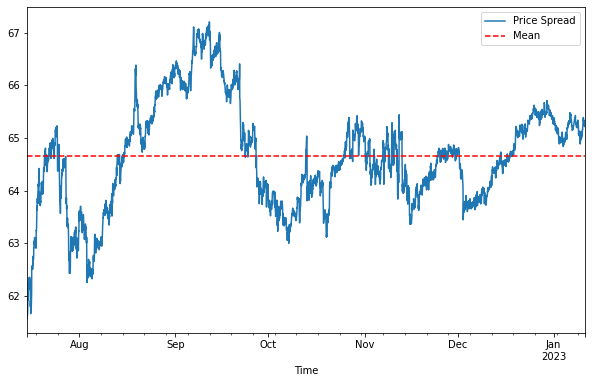

In [16]:
spread.plot() # Plot the spread
plt.axhline(spread.mean(), color='red', linestyle='--') # Add the mean
plt.xlabel('Time')
plt.legend(['Price Spread', 'Mean'])
plt.show()

In [17]:
def zscore(x, window):
    r = x.rolling(window=window)
    m = r.mean().shift(1)
    s = r.std(ddof=0).shift(1)
    z = (x-m)/s
    return z

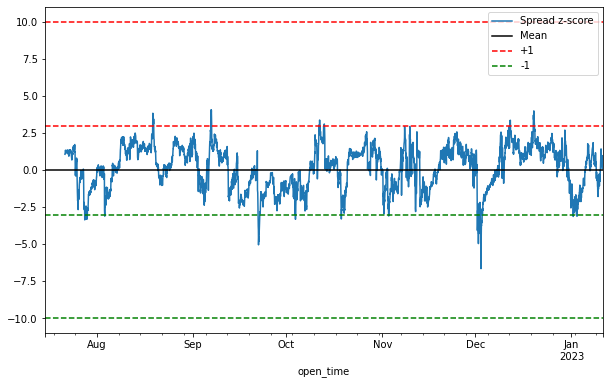

In [18]:
zscore(spread, half_life).tail(10000).plot()
plt.axhline(0, color='black')
plt.axhline(3, color='red', linestyle='--')
plt.axhline(-3, color='green', linestyle='--')
plt.axhline(10, color='red', linestyle='--')
plt.axhline(-10, color='green', linestyle='--')
plt.legend(['Spread z-score', 'Mean', '+1', '-1'])
plt.show()